In [15]:
# Colab cell (bash)
# install required libs
!pip install --quiet transformers ftfy accelerate safetensors torchvision gradio --upgrade

In [16]:
# Colab cell (python)
# basics
import os
from pathlib import Path
import torch
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [17]:
# Colab cell
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "openai/clip-vit-base-patch32"  # lightweight, fast
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)


In [24]:
# Colab cell: fetch images from URLs
image_urls = [
  # AI-generated images (get from free tools)
  # "https://api.dicebear.com/7.x/avataaars/svg?seed=FireflyGenAI", # Removed SVG URL

  # Real images (e.g., from Unsplash)
  "https://images.unsplash.com/photo-1501594907352-04cda38ebc29",
  "https://images.unsplash.com/photo-1529626455594-4ff0802cfb7e"
]

def load_image_from_url(url):
    resp = requests.get(url)
    return Image.open(BytesIO(resp.content)).convert("RGB")

image_paths = []
images = []
for i, url in enumerate(image_urls):
    img = load_image_from_url(url)
    images.append(img)
    fname = f"img_{i}.jpg"
    img.save(fname)
    image_paths.append(fname)

image_paths

['img_0.jpg', 'img_1.jpg']

In [25]:
# Colab cell
# Example prompts describing image intent (or the prompt used to generate them)
prompts = [
    "A cityscape at sunset",
    "A realistic portrait of a woman",


]

# If using image URLs without known prompts, use generic prompts for alignment checks


In [26]:
# Colab cell
def embed_image(image_path_or_pil):
    if isinstance(image_path_or_pil, str):
        image = Image.open(image_path_or_pil).convert("RGB")
    else:
        image = image_path_or_pil
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        img_embeds = model.get_image_features(**inputs)
        img_embeds = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)
    return img_embeds.cpu().numpy()

def embed_text(texts):
    inputs = processor(text=texts, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        txt_embeds = model.get_text_features(**inputs)
        txt_embeds = txt_embeds / txt_embeds.norm(p=2, dim=-1, keepdim=True)
    return txt_embeds.cpu().numpy()

# compute embeddings for images
image_embeddings = []
for p in image_paths:
    image_embeddings.append(embed_image(p))

text_embeddings = embed_text(prompts)  # shape: (n_prompts, dim)


In [27]:
# Colab cell
from sklearn.metrics.pairwise import cosine_similarity

# If #images == #prompts and you want pairwise alignment:
scores = []
for i, img_emb in enumerate(image_embeddings):
    # compare to the corresponding prompt (if aligned 1:1)
    if i < len(prompts):
        sim = cosine_similarity(img_emb, text_embeddings[i:i+1])[0,0]
    else:
        # fallback: compare to first prompt or mean of prompts
        sim = cosine_similarity(img_emb, text_embeddings.mean(axis=0, keepdims=True))[0,0]
    scores.append(float(sim))

# present scores
df = pd.DataFrame({"image": image_paths, "alignment_score": scores})
df


,image,alignment_score
0,img_0.jpg,0.179487
1,img_1.jpg,0.246791


In [28]:
# Colab cell
# Provide or upload/reference a few high-quality reference images (HQ)
# e.g., place HQ images in ./hq_images/
hq_folder = "hq_images"
hq_paths = []  # fill with paths to your HQ images
# Example: if you uploaded or saved hq images, populate hq_paths accordingly

# compute HQ embeddings
hq_embeddings = [embed_image(p) for p in hq_paths] if hq_paths else []

def aesthetic_score(img_emb, hq_embs):
    if len(hq_embs)==0:
        # fallback: use overall brightness/entropy as a primitive aesthetic proxy
        return None
    sims = [cosine_similarity(img_emb, he)[0,0] for he in hq_embs]
    return float(np.mean(sims))

aesthetic_scores = []
for emb in image_embeddings:
    sc = aesthetic_score(emb, hq_embeddings)
    aesthetic_scores.append(sc)

df["aesthetic_score"] = aesthetic_scores
df


,image,alignment_score,aesthetic_score
0,img_0.jpg,0.179487,None
1,img_1.jpg,0.246791,None


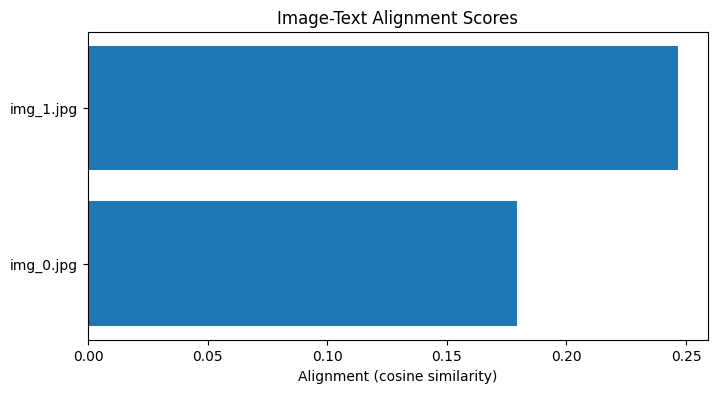

In [29]:
# Colab cell
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.barh(df["image"], df["alignment_score"])
plt.xlabel("Alignment (cosine similarity)")
plt.title("Image-Text Alignment Scores")
plt.show()


In [30]:
# Colab cell
import gradio as gr

def evaluate_image(img, prompt="A high-quality photograph"):
    # img is PIL Image
    img_emb = embed_image(img)
    txt_emb = embed_text([prompt])
    align = float(cosine_similarity(img_emb, txt_emb)[0,0])
    # aesthetic (if HQ embeddings exist)
    aest = aesthetic_score(img_emb, hq_embeddings) if hq_embeddings else None
    return {"alignment_score": round(align,4), "aesthetic_score": round(aest,4) if aest else "N/A"}

demo = gr.Interface(
    fn=evaluate_image,
    inputs=[gr.Image(type="pil"), gr.Textbox(lines=1, placeholder="Describe expected content or style")],
    outputs=["label", "label"],
    title="Generative Image Evaluator (CLIP)",
    description="Upload an image and a prompt — returns alignment and (optional) aesthetic score."
)
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://58843819dae565f075.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
